In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.decomposition import MiniBatchSparsePCA, KernelPCA

Antes de empezar con el preprocesamiento de los datos, se seleccionan aquellas variables de interés para aplicar al modelo.

In [2]:
sanctionlist = pd.read_csv('datos_entrada_script_04_y_PowerBI/sanctionlist.csv').iloc[:,1:]
sanctionlist

,Name,EntityType,Address,Country,Origin,City
0,AEROCARIBBEAN AIRLINES,ENTERPRISE,NaN,CUBA,EEUU,HAVANA
1,"ANGLO-CARIBBEAN CO., LTD.",ENTERPRISE,"IBEX HOUSE, THE MINORIES",UNITED KINGDOM,EEUU,LONDON
2,BANCO NACIONAL DE CUBA,ENTERPRISE,ZWEIERSTRASSE 35,SWITZERLAND,EEUU,ZURICH
3,BANCO NACIONAL DE CUBA,ENTERPRISE,AVENIDA DE CONCHA ESPINA 8,SPAIN,EEUU,MADRID
4,BANCO NACIONAL DE CUBA,ENTERPRISE,"DAI-ICHI BLDG. 6TH FLOOR, 10-2 NIHOMBASHI, 2-C...",JAPAN,EEUU,TOKYO
...,...,...,...,...,...,...
25822,VIKTOR YANUKOVYCH,PERSON,NaN,NaN,UE,NaN
25823,VIKTOR FEDOROVICH YANUKOVYCH,PERSON,NaN,NaN,UE,NaN
25824,YEVHEN VITALIIOVYCH BALYTSKIY,PERSON,NaN,NaN,UE,NaN
25825,YEVGENIY VITALIEVICH BALYTSKIY,PERSON,NaN,NaN,UE,NaN


In [3]:
sanctionlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25827 entries, 0 to 25826
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        25827 non-null  object
 1   EntityType  25827 non-null  object
 2   Address     8230 non-null   object
 3   Country     14789 non-null  object
 4   Origin      25827 non-null  object
 5   City        12681 non-null  object
dtypes: object(6)
memory usage: 1.2+ MB


Hay demasiados valores nulos para columnas como 'Address', 'Country' o 'City'. Por estudios anteriores se sabe que la mayoría de estos valores nulos proceden de la tabla de la Unión Europea. Se llega a la conclusión de que el dataset de la Unión Europea es demasiado malo para aplicarle un algoritmo de Machine Learning. Por ello, finalmente se opta por utilizar únicamente el dataset de Estados Unidos para el entrenamiento del algoritmo de aprendizaje no supervisado. 

In [3]:
ml_ns = sanctionlist[sanctionlist['Origin']=='EEUU']
ml_ns

,Name,EntityType,Address,Country,Origin,City
0,AEROCARIBBEAN AIRLINES,ENTERPRISE,NaN,CUBA,EEUU,HAVANA
1,"ANGLO-CARIBBEAN CO., LTD.",ENTERPRISE,"IBEX HOUSE, THE MINORIES",UNITED KINGDOM,EEUU,LONDON
2,BANCO NACIONAL DE CUBA,ENTERPRISE,ZWEIERSTRASSE 35,SWITZERLAND,EEUU,ZURICH
3,BANCO NACIONAL DE CUBA,ENTERPRISE,AVENIDA DE CONCHA ESPINA 8,SPAIN,EEUU,MADRID
4,BANCO NACIONAL DE CUBA,ENTERPRISE,"DAI-ICHI BLDG. 6TH FLOOR, 10-2 NIHOMBASHI, 2-C...",JAPAN,EEUU,TOKYO
...,...,...,...,...,...,...
15253,GLORY HARVEST,VESSEL,NaN,NaN,EEUU,NaN
15254,TORNADO CASH,ENTERPRISE,NaN,NaN,EEUU,NaN
15255,"TWEHWAY, BILL",INDIVIDUAL,NaN,LIBERIA,EEUU,MONROVIA
15256,"CEPHUS, SAYMA SYRENIUS",INDIVIDUAL,NaN,LIBERIA,EEUU,NaN


In [4]:
ml_ns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15258 entries, 0 to 15257
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        15258 non-null  object
 1   EntityType  15258 non-null  object
 2   Address     8230 non-null   object
 3   Country     12846 non-null  object
 4   Origin      15258 non-null  object
 5   City        10043 non-null  object
dtypes: object(6)
memory usage: 834.4+ KB


In [5]:
ml_ns.describe()

,Name,EntityType,Address,Country,Origin,City
count,15258,15258,8230,12846,15258,10043
unique,10459,4,7099,178,1,2053
top,AERO CONTINENTE S.A,INDIVIDUAL,"EAST SHAHID ATEFI STREET 35, AFRICA BOULEVARD,...",RUSSIA,EEUU,TEHRAN
freq,47,7291,30,1718,15258,745


A partir del resultado de describe() se puede estudiar la cardinalidad de cada variable:

In [6]:
for i in ml_ns.describe().columns:
    print("La variable", i, "presenta un", round(ml_ns.describe().loc['unique',i]/ml_ns.describe().loc['count',i]*100,2),'% de valores únicos sobre el total de valores no nulos.\n')

La variable Name presenta un 68.55 % de valores únicos sobre el total de valores no nulos.

La variable EntityType presenta un 0.03 % de valores únicos sobre el total de valores no nulos.

La variable Address presenta un 86.26 % de valores únicos sobre el total de valores no nulos.

La variable Country presenta un 1.39 % de valores únicos sobre el total de valores no nulos.

La variable Origin presenta un 0.01 % de valores únicos sobre el total de valores no nulos.

La variable City presenta un 20.44 % de valores únicos sobre el total de valores no nulos.



A mayor porcentaje, mayor es la cardinalidad. No interesan las variables con un porcentaje de valores únicos alto porque esto podría acarrear problema de rendimiento y de calidad del modelo. Debido a esto, inicialmente se eliminaron las variables 'Name' y 'Address' del dataset para entrenar el modelo.

Sin embargo, el hecho de eliminar estas dos variables hacía que el dataset tuviera muchos valores duplicados. De modo que se perdía gran cantidad de información para el agrupamiento y el modelo de clustering solo agrupaba por los valores únicos.

Para evitar esto, se volvió a introducir al dataset de entrenamiento la variable 'Name' y se eliminaron los duplicados. La variable 'Address' se eliminó definitivamente porque además de presentar alta cardinalidad también presenta muchos valores nulos.

La variable 'Origin' se puede eliminar porque ahora solo tiene un valor, por lo que no aporta información.

El dataset para el modelo ML queda como:

In [8]:
ml_ns = ml_ns.drop(columns=['Address','Origin'],errors='ignore').drop_duplicates().reset_index(drop=True)
ml_ns

,Name,EntityType,Country,City
0,AEROCARIBBEAN AIRLINES,ENTERPRISE,CUBA,HAVANA
1,"ANGLO-CARIBBEAN CO., LTD.",ENTERPRISE,UNITED KINGDOM,LONDON
2,BANCO NACIONAL DE CUBA,ENTERPRISE,SWITZERLAND,ZURICH
3,BANCO NACIONAL DE CUBA,ENTERPRISE,SPAIN,MADRID
4,BANCO NACIONAL DE CUBA,ENTERPRISE,JAPAN,TOKYO
...,...,...,...,...
12885,GLORY HARVEST,VESSEL,NaN,NaN
12886,TORNADO CASH,ENTERPRISE,NaN,NaN
12887,"TWEHWAY, BILL",INDIVIDUAL,LIBERIA,MONROVIA
12888,"CEPHUS, SAYMA SYRENIUS",INDIVIDUAL,LIBERIA,NaN


A la hora de definir el modelo de aprendizaje no supervisado se siguieron los siguientes pasos:

- Todas las variables son categóricas nominales. Hay que sustituirlas por valores numéricos por algún método de codificación
    
- Una vez codificadas las variables, se imputan los valores nulos con KNNImputer.

- Para reducir las dimensiones se utiliza PCA.

- Hecho lo anterior, se tienen los datos listos para introducirlos en un modelo de clustering

## Modelo KMeans:

## Modelo 1:

Tras varios ajustes de los parámetros para mejorar el valor de la silueta nos quedamos con el siguiente modelo:

In [9]:
#1 Se preprocesan los datos antes de aplicarles KMeans



encoder_name = Pipeline([
                        ('oe',OrdinalEncoder(encoded_missing_value=np.nan)), # Valor por defecto de encoded_missing_value es nan
                        ('ms',MinMaxScaler(feature_range=(-1e-4,1e-4))) #Por defecto deja los valores nulos como np.nan
                         
    
])
#print(encoder_name.fit(ml_ns))

encoder = ColumnTransformer([
                            ('encoder_name',encoder_name,['Name']),
                            ('binary',BinaryEncoder(handle_missing='return_nan'),['EntityType','Country','City'])
])
#print(encoder.fit(ml_ns))

preprocessing = Pipeline([
                        ('encoder',encoder), 
                        ('imputer',SimpleImputer(strategy='constant',fill_value=0)),
                        ('pca',MiniBatchSparsePCA(n_components=3, batch_size=20,random_state=10)),
                        
])

print(preprocessing.fit(ml_ns))

preprocessing_transform = preprocessing.fit_transform(ml_ns)

#2 Los datos preprocesados se meten al algoritmo KMeans para grupos de 2 a 6 calculándose la silueta de cada grupo

list_silhouette=[]
for i in range(2,7):
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
 
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

print(list_silhouette)

Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('encoder_name',
                                                  Pipeline(steps=[('oe',
                                                                   OrdinalEncoder()),
                                                                  ('ms',
                                                                   MinMaxScaler(feature_range=(-0.0001,
                                                                                               0.0001)))]),
                                                  ['Name']),
                                                 ('binary',
                                                  BinaryEncoder(handle_missing='return_nan'),
                                                  ['EntityType', 'Country',
                                                   'City'])])),
                ('imputer', SimpleImputer(fill_value=0, strategy='constant')),
                ('pca',
    

In [10]:
preprocessing_transform.shape

(12890, 3)

For n_clusters = 2 The average silhouette_score is : 0.315942470277085
For n_clusters = 3 The average silhouette_score is : 0.32745621367339267
For n_clusters = 4 The average silhouette_score is : 0.33255346744531494
For n_clusters = 5 The average silhouette_score is : 0.3026100580025034
For n_clusters = 6 The average silhouette_score is : 0.34910544060733945


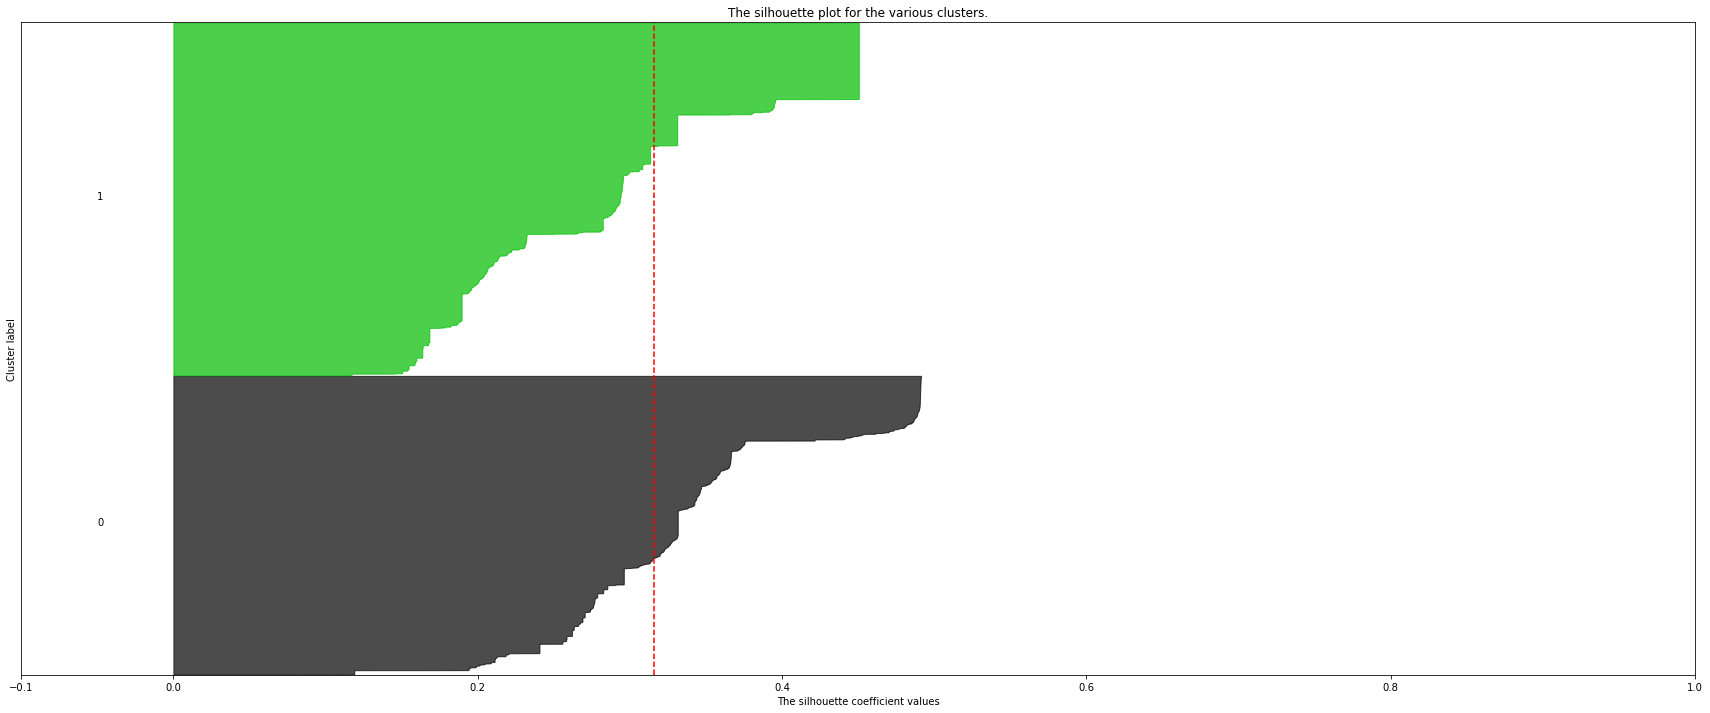

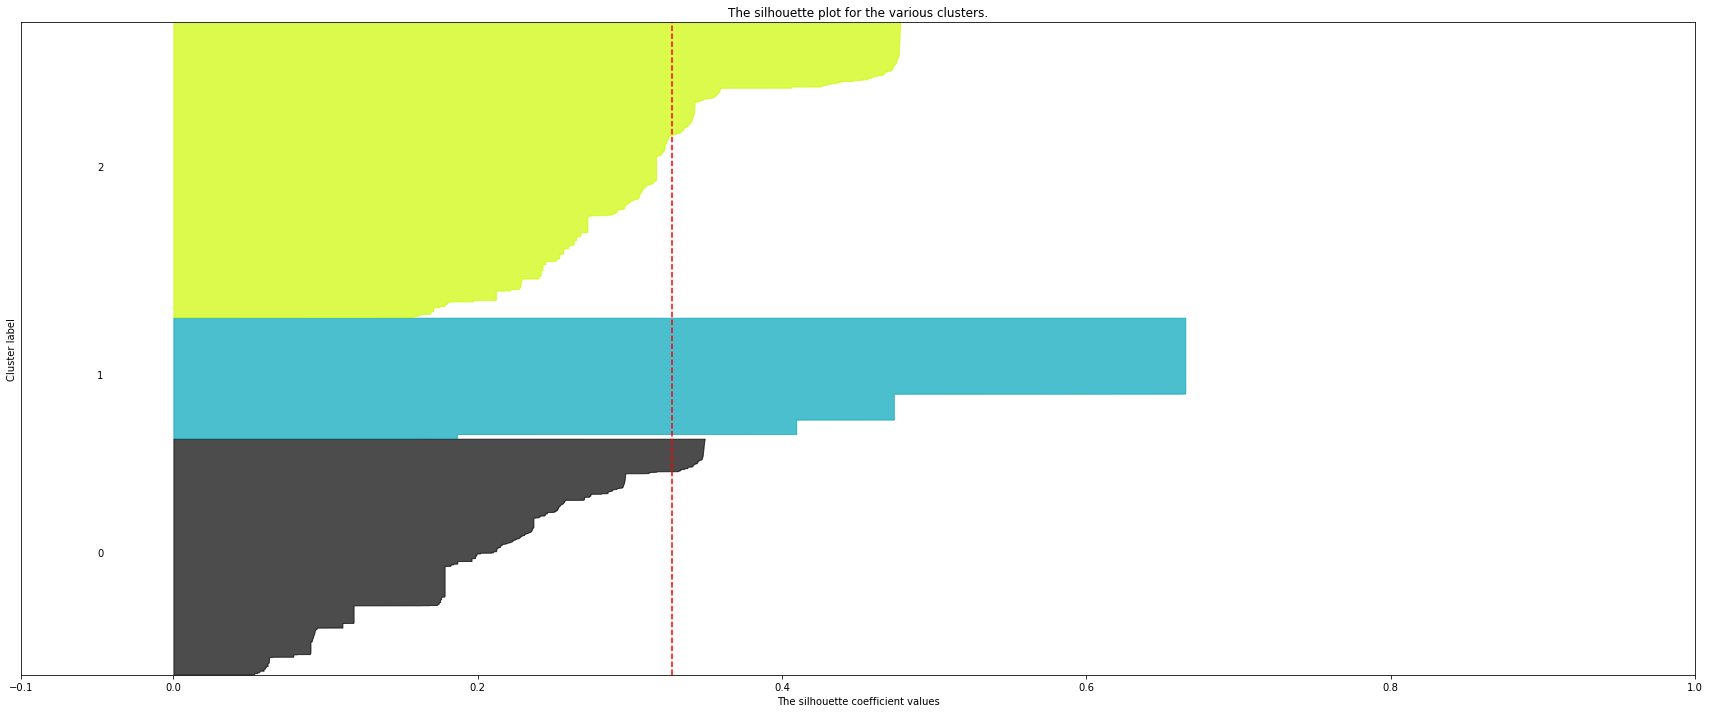

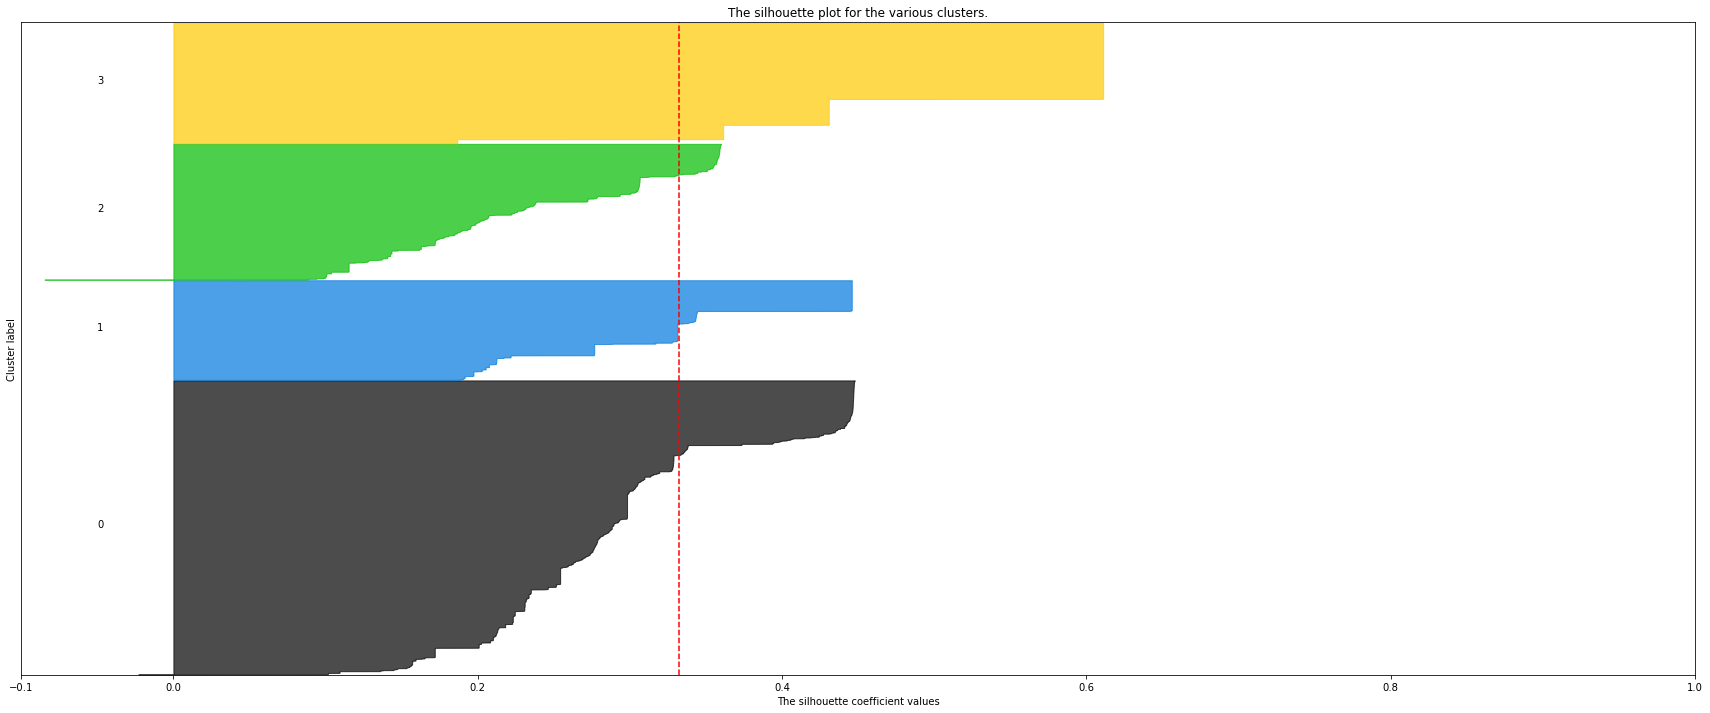

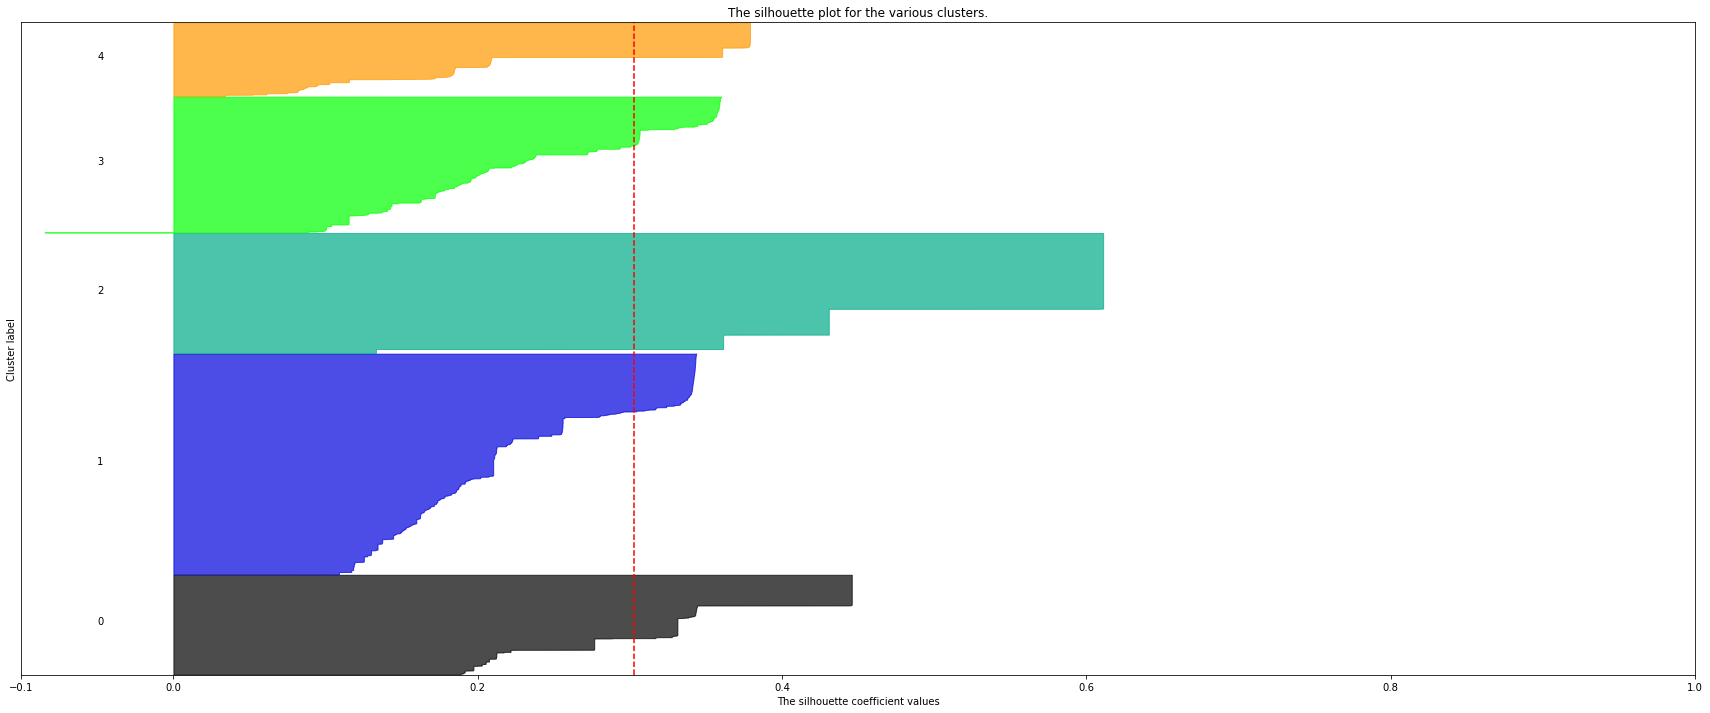

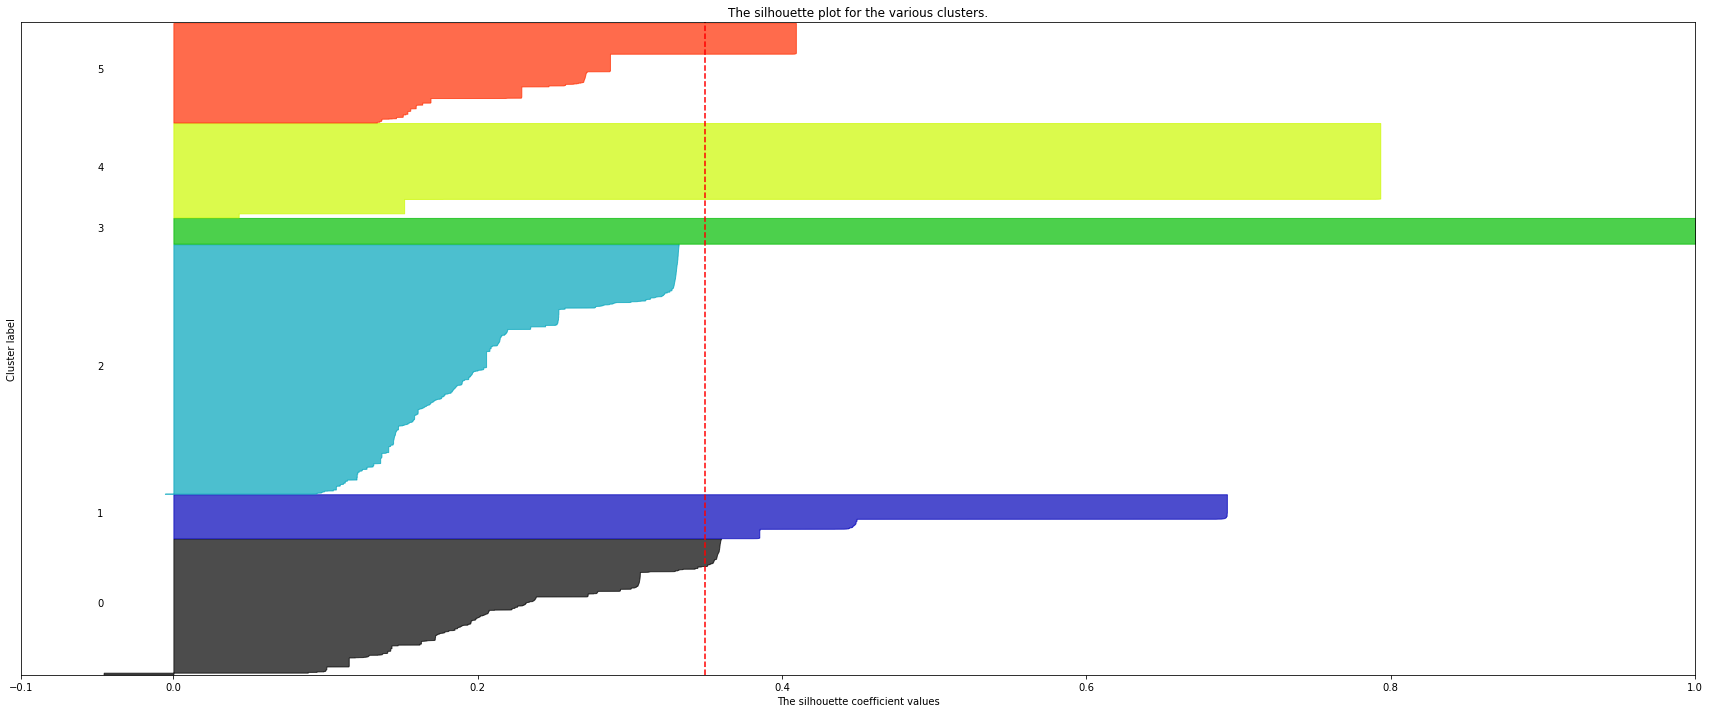

In [19]:
for n_clusters in range(2,7):

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(30, 12)

    X = preprocessing_transform

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters,n_init=20,random_state=25)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

   
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])



In [23]:
pd.DataFrame(sample_silhouette_values)

,0
0,0.328059
1,0.126924
2,0.330672
3,0.330116
4,0.330442
...,...
12885,1.000000
12886,0.042910
12887,0.358686
12888,0.269664


In [24]:
pd.DataFrame(sample_silhouette_values).drop_duplicates()

,0
0,0.328059
1,0.126924
2,0.330672
3,0.330116
4,0.330442
...,...
12883,0.188988
12884,0.175612
12887,0.358686
12888,0.269664


In [25]:
pd.DataFrame(preprocessing_transform)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.827418,0.056553,-0.080432,-0.137350,0.065951,-0.061485,-0.051246,-0.137685,-0.001772,-0.008845,...,-0.041046,-0.003788,0.035918,0.000568,0.022210,0.038118,0.001208,-0.125333,0.007880,0.029011
1,-0.835805,0.050920,-0.089506,-0.148171,0.072623,-0.075678,-0.064126,-0.181590,0.011285,-0.013358,...,0.998024,0.078337,-0.231619,-0.019468,-0.063748,-0.082318,0.004149,0.128576,-0.009679,-0.055740
2,-0.826043,0.054957,-0.080502,-0.137638,0.059881,-0.061367,-0.052974,-0.130680,-0.003921,-0.007877,...,-0.038336,-0.003963,0.031362,0.008929,0.013054,0.026832,-0.002490,-0.074600,0.001934,0.014071
3,-0.825112,0.056725,-0.079229,-0.134344,0.067968,-0.059957,-0.048199,-0.135896,0.000346,-0.008757,...,-0.035060,-0.006434,0.037071,0.006147,0.016494,0.035060,-0.002406,-0.086680,-0.000811,0.037982
4,-0.825577,0.055320,-0.079975,-0.137086,0.059453,-0.060579,-0.052333,-0.128497,-0.004619,-0.007698,...,-0.035855,-0.003642,0.028035,0.007907,0.011229,0.023192,-0.001572,-0.066274,0.002584,0.009735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12885,0.571826,1.108011,-0.102606,-0.401958,-0.357382,0.022615,-0.138391,0.331403,0.643444,0.002922,...,0.000684,-0.000057,0.003180,0.001825,0.000123,0.001120,-0.000123,0.000039,0.000494,0.001249
12886,-0.088186,1.152733,0.010859,-0.182253,0.032870,0.049236,0.048357,-0.122770,-0.404001,-0.005443,...,-0.005966,-0.001041,-0.033578,-0.024252,0.000586,-0.012375,0.001739,-0.005365,-0.008076,-0.013889
12887,0.354662,-0.668677,-0.198224,-0.063986,-0.118172,-0.153829,-0.104185,-0.111022,0.083440,0.001099,...,-0.030413,-0.000738,0.050035,0.023792,0.011995,0.032288,-0.002975,-0.057349,0.009761,0.018904
12888,0.810061,-0.082250,0.032846,0.234912,0.313991,0.005997,0.124752,-0.153269,0.133421,-0.009704,...,0.015442,-0.012722,0.048733,-0.001754,0.019315,0.037689,-0.001930,-0.037832,0.000327,0.088328


In [26]:
pd.DataFrame(preprocessing_transform).drop_duplicates()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.827418,0.056553,-0.080432,-0.137350,0.065951,-0.061485,-0.051246,-0.137685,-0.001772,-0.008845,...,-0.041046,-0.003788,0.035918,0.000568,0.022210,0.038118,0.001208,-0.125333,0.007880,0.029011
1,-0.835805,0.050920,-0.089506,-0.148171,0.072623,-0.075678,-0.064126,-0.181590,0.011285,-0.013358,...,0.998024,0.078337,-0.231619,-0.019468,-0.063748,-0.082318,0.004149,0.128576,-0.009679,-0.055740
2,-0.826043,0.054957,-0.080502,-0.137638,0.059881,-0.061367,-0.052974,-0.130680,-0.003921,-0.007877,...,-0.038336,-0.003963,0.031362,0.008929,0.013054,0.026832,-0.002490,-0.074600,0.001934,0.014071
3,-0.825112,0.056725,-0.079229,-0.134344,0.067968,-0.059957,-0.048199,-0.135896,0.000346,-0.008757,...,-0.035060,-0.006434,0.037071,0.006147,0.016494,0.035060,-0.002406,-0.086680,-0.000811,0.037982
4,-0.825577,0.055320,-0.079975,-0.137086,0.059453,-0.060579,-0.052333,-0.128497,-0.004619,-0.007698,...,-0.035855,-0.003642,0.028035,0.007907,0.011229,0.023192,-0.001572,-0.066274,0.002584,0.009735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12885,0.571826,1.108011,-0.102606,-0.401958,-0.357382,0.022615,-0.138391,0.331403,0.643444,0.002922,...,0.000684,-0.000057,0.003180,0.001825,0.000123,0.001120,-0.000123,0.000039,0.000494,0.001249
12886,-0.088186,1.152733,0.010859,-0.182253,0.032870,0.049236,0.048357,-0.122770,-0.404001,-0.005443,...,-0.005966,-0.001041,-0.033578,-0.024252,0.000586,-0.012375,0.001739,-0.005365,-0.008076,-0.013889
12887,0.354662,-0.668677,-0.198224,-0.063986,-0.118172,-0.153829,-0.104185,-0.111022,0.083440,0.001099,...,-0.030413,-0.000738,0.050035,0.023792,0.011995,0.032288,-0.002975,-0.057349,0.009761,0.018904
12888,0.810061,-0.082250,0.032846,0.234912,0.313991,0.005997,0.124752,-0.153269,0.133421,-0.009704,...,0.015442,-0.012722,0.048733,-0.001754,0.019315,0.037689,-0.001930,-0.037832,0.000327,0.088328


In [16]:
#1 Se preprocesan los datos antes de aplicarles KMeans



encoder_name = Pipeline([
                        ('oe',OrdinalEncoder(encoded_missing_value=np.nan)), # Valor por defecto de encoded_missing_value es nan
                        ('ms',MinMaxScaler(feature_range=(-1e-4,1e-4))) #Por defecto deja los valores nulos como np.nan
                         
    
])
#print(encoder_name.fit(ml_ns))

encoder = ColumnTransformer([
                            ('encoder_name',encoder_name,['Name']),
                            ('binary',BinaryEncoder(handle_missing='return_nan'),['EntityType','Country','City'])
])
#print(encoder.fit(ml_ns))

preprocessing = Pipeline([
                        ('encoder',encoder), 
                        ('imputer',SimpleImputer(strategy='constant',fill_value=0)),
                        #('pca',MiniBatchSparsePCA(n_components=3, batch_size=20,random_state=10)),
                        
])

print(preprocessing.fit(ml_ns))

preprocessing_transform = preprocessing.fit_transform(ml_ns.drop_duplicates())

#2 Los datos preprocesados se meten al algoritmo KMeans para grupos de 2 a 6 calculándose la silueta de cada grupo

list_silhouette=[]
for i in range(2,7):
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
 
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

print(list_silhouette)

Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('encoder_name',
                                                  Pipeline(steps=[('oe',
                                                                   OrdinalEncoder()),
                                                                  ('ms',
                                                                   MinMaxScaler(feature_range=(-0.0001,
                                                                                               0.0001)))]),
                                                  ['Name']),
                                                 ('binary',
                                                  BinaryEncoder(handle_missing='return_nan'),
                                                  ['EntityType', 'Country',
                                                   'City'])])),
                ('imputer', SimpleImputer(fill_value=0, strategy='constant'))])
[0.18316953227338656, 0.168

## Modelo 2:

Se puede utilizar el atributo explained_variance_ratio_ para conocer el grado de varianza de cada dimensión y así saber si estamos eliminando demasiadas dimensiones o demasiado pocas. El problema es que MiniBatchSparsePCA no admite este atributo. Creamos otro modelo con PCA clásico para poder conocer el atributo y así tener un mejor conocimiento de las variables seleccionadas.

In [18]:
from sklearn.decomposition import PCA

#1 Se preprocesan los datos antes de aplicarles KMeans

encoder = OneHotEncoder(sparse=False) # Imputa los nulos como filas de ceros
encoded = encoder.fit_transform(ml_ns)

PCA = PCA(n_components=30)
PCA.fit_transform(encoded) # NO se puede hacer pipeline si se quiere aplicar explained_variance_ratio

preprocessing_transform = PCA.fit_transform(encoded)
 
#2 Los datos preprocesados se meten al algoritmo KMeans para grupos de 2 a 6 calculándose la silueta de cada grupo

list_silhouette=[]
for i in range(2,7):
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

    print('Silhouette for ',i,'clusters: %.3f \n' % silhouette)

#3 Se calcula el ratio de la varianza para cada dimensión seleccionada con PCA y el ratio total

formatted_list_variance_ratio = [ '%.4f' % elem for elem in PCA.explained_variance_ratio_]

print('Variance of each component: ',formatted_list_variance_ratio)
print('\n Total Variance Explained:', round(sum(list(PCA.explained_variance_ratio_))*100, 2))

Silhouette for  2 clusters: 0.316 

Silhouette for  3 clusters: 0.327 

Silhouette for  4 clusters: 0.333 

Silhouette for  5 clusters: 0.303 

Silhouette for  6 clusters: 0.349 

Variance of each component:  ['0.1736', '0.0733', '0.0396', '0.0324', '0.0242', '0.0220', '0.0170', '0.0141', '0.0112', '0.0085', '0.0084', '0.0076', '0.0075', '0.0068', '0.0063', '0.0059', '0.0057', '0.0051', '0.0048', '0.0043', '0.0041', '0.0040', '0.0037', '0.0035', '0.0034', '0.0032', '0.0030', '0.0029', '0.0029', '0.0027']

 Total Variance Explained: 51.18


# Modelo 3

Como el modelo 2 pero cambiando el tipo de codificacion e imputación para tener menos variables. Lo que lleva a un ajuste de PCA a dimensiones más bajas.

In [69]:
from sklearn.decomposition import PCA

#1 Se preprocesan los datos antes de aplicarles KMeans

encoder = BinaryEncoder(handle_missing='return_nan') # Deja los nulos como nan
encoded = encoder.fit_transform(ml_ns)

#imputer = SimpleImputer(strategy='mean')
imputer = KNNImputer(n_neighbors=5) #Produce mejores resultados que simple imputer para media
imputed = imputer.fit_transform(encoded)

PCA = PCA(n_components=12)
PCA.fit_transform(imputed) # NO se puede hacer pipeline si se quiere aplicar explained_variance_ratio

preprocessing_transform = PCA.fit_transform(imputed)
 
#2 Los datos preprocesados se meten al algoritmo KMeans para grupos de 2 a 6 calculándose la silueta de cada grupo

list_silhouette=[]
for i in range(2,7):
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform)
    
    silhouette = silhouette_score(preprocessing_transform,kmeans.labels_)
    
    list_silhouette.append(silhouette)

    print('Silhouette for ',i,'clusters: %.3f \n' % silhouette)

#3 Se calcula el ratio de la varianza para cada dimensión seleccionada con PCA y el ratio total

formatted_list_variance_ratio = [ '%.2f' % elem for elem in PCA.explained_variance_ratio_]

print('Variance of each component: ',formatted_list_variance_ratio)
print('\n Total Variance Explained:', round(sum(list(PCA.explained_variance_ratio_))*100, 2))

Silhouette for  2 clusters: 0.119 

Silhouette for  3 clusters: 0.111 

Silhouette for  4 clusters: 0.116 

Silhouette for  5 clusters: 0.104 

Silhouette for  6 clusters: 0.106 

Variance of each component:  ['0.09', '0.06', '0.05', '0.05', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.03']

 Total Variance Explained: 53.86


# Modelo DBSCAN

In [5]:
from sklearn.cluster import DBSCAN

X = preprocessing_transform
db = DBSCAN(eps=0.).fit(X)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of noise points: %d" % n_noise_)
print("Estimated number of clusters: %d" % n_clusters_)
print("Silhouette Coefficient: %0.3f \n" % silhouette_score(X, labels))

Estimated number of noise points: 440
Estimated number of clusters: 178
Silhouette Coefficient: 0.310 



Se añade una columna al dataset preprocesado para indicarle los outliers y eliminarlos:

In [72]:
copy = pd.DataFrame(preprocessing_transform)
clusters = db.fit_predict(X)
copy['outliers'] = clusters

preprocessing_transform_nooutlier = copy[copy['outliers']!=-1].drop(columns=['outliers'])

In [73]:
list_silhouette=[]
for i in range(2,7):
    
    kmeans = KMeans(n_clusters=i,n_init=20,random_state=25).fit(preprocessing_transform_nooutlier)
    
    silhouette = silhouette_score(preprocessing_transform_nooutlier,kmeans.labels_)
    
    list_silhouette.append(silhouette)

list_silhouette

[0.39370363271150227,
 0.43356602611979606,
 0.4517817258764108,
 0.5036796371276822,
 0.5128273324417021]

A mejorado el valor de silueta respecto a aplicar KMeans sin eliminar outliers

Se intentó hacer un dendograma. Pero eran demasiados registros como para poderlos representar gráficamente de esta forma.